In [1]:
import random
import numpy as np
import tensorflow.keras
#import wandb
#from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

from tensorflow.keras import applications

from tensorflow.keras.preprocessing import image
import os

import re

Number of Cat images -  166
subject05.rightlight


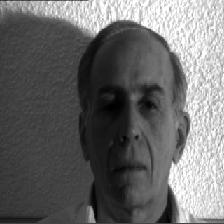

In [2]:
#http://vision.ucsd.edu/content/yale-face-database
img_dir = "../data/yalefaces/"
faceImages = os.listdir(img_dir)
print("Number of Cat images - ",str(len(faceImages)))
print(faceImages[1])

#img_path = 'elephant.jpg'
img = image.load_img(img_dir + faceImages[1], target_size=(224, 224))
x = image.img_to_array(img)

img

In [3]:
x.shape

(224, 224, 3)

In [4]:
x_train = np.zeros((len(faceImages), 224, 224, 3))
y_train = np.empty((len(faceImages),), dtype=np.object_)
for i, face in enumerate(faceImages):
    img = image.load_img(img_dir + face, target_size=(224, 224))
    x = image.img_to_array(img)
    y = face[ : face.index('.')]
    x_train[i] = x
    y_train[i] = y
    
print(x_train.shape)
print(y_train.shape)

(166, 224, 224, 3)
(166,)


In [5]:
y_train

array(['subject05', 'subject05', 'subject07', 'subject09', 'subject07',
       'subject08', 'subject11', 'subject04', 'subject05', 'subject09',
       'subject06', 'subject13', 'subject07', 'subject03', 'subject09',
       'subject15', 'subject10', 'subject12', 'subject11', 'subject10',
       'subject11', 'subject03', 'subject03', 'subject09', 'subject11',
       'subject12', 'subject12', 'subject13', 'subject10', 'subject14',
       'subject12', 'subject09', 'subject09', 'subject02', 'subject12',
       'subject15', 'subject03', 'subject04', 'subject01', 'subject02',
       'subject06', 'subject06', 'subject13', 'subject11', 'subject10',
       'subject09', 'subject02', 'subject13', 'subject02', 'subject04',
       'subject02', 'subject11', 'subject02', 'subject09', 'subject08',
       'subject12', 'subject01', 'subject05', 'subject12', 'subject01',
       'subject15', 'subject05', 'subject08', 'subject05', 'subject02',
       'subject01', 'subject13', 'subject11', 'subject07', 'subj

In [6]:
np.where(y_train == 'subject05')

(array([  0,   1,   8,  57,  61,  63,  97,  98, 111, 140, 142]),)

In [7]:
y_train[8]

'subject05'

In [8]:
np.unique(y_train)

array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype=object)

In [9]:
random.choice([1,2,3,1,3,4,3,2,2,3,3,3])

4

In [10]:
random.randint(0, 9)

7

In [11]:
# make pairs
def make_pairs(x, y):
    classes = np.unique(y_train)
    num_classes = len(classes)
    
    face_indices_dict = {cls:np.where(y == cls)[0] for cls in classes}
    #print(face_indices_dict)
    #print(digit_indices)
    #print('len *****', len(digit_indices))
    #print('3 digit array', digit_indices[3])
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        for _ in range(5):
            idx2 = random.choice(face_indices_dict[label1])
            x2 = x[idx2]
            pairs += [[x1, x2]]
            labels += [1]
    
        # add a not matching example
        other_labels = [cls for cls in classes if cls not in [label1]]
        
        label2 = random.choice(other_labels)

        for _ in range(5):
        #print(label1, ' --- ', label2)    
            idx2 = random.choice(face_indices_dict[label2])
            x2 = x[idx2]
            pairs += [[x1, x2]]
            labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
#pairs_test, labels_test = make_pairs(x_test, y_test)

In [12]:
x_train.shape

(166, 224, 224, 3)

In [13]:
pairs_train.shape

(1660, 2, 224, 224, 3)

In [14]:
labels_train.shape

(1660,)

In [15]:
pairs_train[0,0,:].shape

(224, 224, 3)

In [16]:
def showPic(pixels):
    image = pixels/np.amax(pixels)
    image = np.clip(image, 0, 1)
    plt.imshow(image)

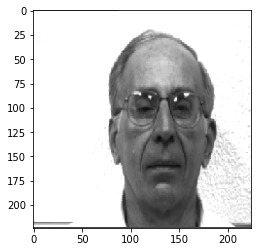

In [17]:
# take a peek at the data
showPic(pairs_train[0,0,:])

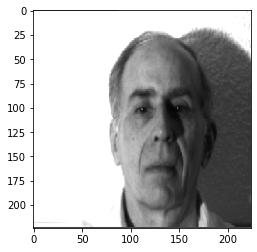

In [18]:
showPic(pairs_train[0,1,:])

In [19]:
labels_train[0]

1

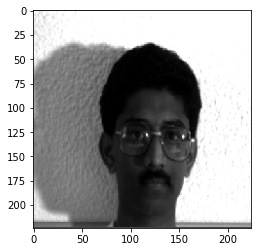

In [20]:
showPic(pairs_train[119,0,:])

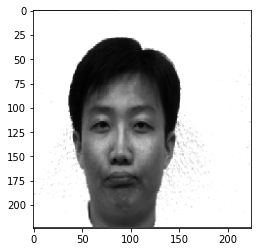

In [21]:
showPic(pairs_train[119,1,:])

In [22]:
labels_train[119]

0

In [23]:
#!pip install tensorflow_addons

In [24]:
'''input_tensor = Input(shape=(224, 224, 3))
resnet_model = applications.ResNet50(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

resnet_model.summary()'''

"input_tensor = Input(shape=(224, 224, 3))\nresnet_model = applications.ResNet50(weights='imagenet',\n                               include_top=False,\n                               input_tensor=input_tensor)\n\nresnet_model.summary()"

In [25]:
import tensorflow_addons as tfa

In [26]:
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon())) # sum_square come as zero 


input_tensor = Input(shape=(224, 224, 3))
vgg16_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg16_model.layers])
    
x = layer_dict['block5_pool'].output
x = Flatten()(x)
x = Dense(256, activation=K.relu)(x)
x = Dense(128, activation=K.relu)(x)

face_encoder_model = Model(inputs=vgg16_model.input, outputs=x)

# Make sure that the pre-trained bottom layers are not trainable

lock_layer_count = len(layer_dict)
print(lock_layer_count)
for layer in face_encoder_model.layers[ :lock_layer_count]:
    layer.trainable = False 


input_anchor_face = Input(shape=(224, 224, 3))
input_pos_or_neg_face = Input(shape=(224, 224, 3))

anchor_siamese_net = face_encoder_model(input_anchor_face)
pos_or_neg_siamese_net = face_encoder_model(input_pos_or_neg_face)

merge_layer = Lambda(euclidean_distance)([anchor_siamese_net, pos_or_neg_siamese_net])

sigmoid_layer = Dense(1, activation="sigmoid")(merge_layer)

model = Model(inputs=[input_anchor_face, input_pos_or_neg_face], outputs=sigmoid_layer)

19


In [27]:
optimizer = SGD(learning_rate=0.000001)

model.compile(loss =tfa.losses.TripletSemiHardLoss(), optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          21170368    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [28]:
pairs_train[:,0].shape

(1660, 224, 224, 3)

In [29]:
pairs_train[:,1].shape

(1660, 224, 224, 3)

In [ ]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=4, epochs=30)

Epoch 1/30
 26/415 [>.............................] - ETA: 17:22 - loss: 0.9276 - accuracy: 0.4405

Kaggle - Challenges in Representation Learning: Facial Expression Recognition Challenge
  * https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion
  * https://www.youtube.com/watch?v=DtBu1u5aBsc

Sliding Window Classifier: Rain Drop Detection
  * https://github.com/tobybreckon/raindrop-detection-cnn/blob/master/raindrop_detection_sliding_window.py

Convolutional implementation of the sliding window algorithm
  * https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0